<a href="https://colab.research.google.com/github/terryspitz/ipython_notebooks/blob/master/deeper/deeperfont_ipynb_2019_04_tri_stacks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

In [0]:
# Install dependencies for colab.research.google.com.
#!pip install -I tensorflow==1.11.0
#!pip install tensorflow-probability-gpu
#!pip install tfp-nightly

# Install dependencies for GCP Deep Learning VM.
! pip3 install tensorflow-gpu
! pip3 install tensorflow-probability-gpu
! pip3 install wrapt

# Install dependencies locally
! pip3 install tensorflow
! pip3 install tensorflow-probability


You are using pip version 19.0.3, however version 19.1 is available.
You should consider upgrading via the 'python -m pip install --upgrade pip' command.


You are using pip version 19.0.3, however version 19.1 is available.
You should consider upgrading via the 'python -m pip install --upgrade pip' command.


You are using pip version 19.0.3, however version 19.1 is available.
You should consider upgrading via the 'python -m pip install --upgrade pip' command.


You are using pip version 19.0.3, however version 19.1 is available.
You should consider upgrading via the 'python -m pip install --upgrade pip' command.


You are using pip version 19.0.3, however version 19.1 is available.
You should consider upgrading via the 'python -m pip install --upgrade pip' command.


In [0]:
from enum import Enum, IntEnum
import math
import os
import time
import collections
import copy
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
print(np.__version__)
import tensorflow as tf
print(tf.__version__)
#import tensorflow_probability as tfp
#import sonnet as snt
#print(snt.__version__)
np.set_printoptions(precision=2)
from PIL import Image, ImageDraw, ImageChops, ImageFont
from IPython.display import display

# hosted colab versions
# np 1.14.6
# tf 1.11.0
# snt 1.23

1.16.2


C:\Users\terry\Anaconda3\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


1.13.1


# Definitions

In [0]:
class Element(IntEnum):
    """
    Enum defining data contents of last dimension
    """
    Vertex = 0
    X = 1
    Y = 2
    Triangle = 3
    Offset1 = 4
    Offset2 = 5
    Size = 5  # size of this enum

In [0]:
#https://raw.githubusercontent.com/terryspitz/ipython_notebooks/master/deeper/TriangleStack.py

class TriangleStack(object):
  Element = collections.namedtuple("Element", ["vertex", "triangle_offsets"])
  # vertex: Optional(List[float, 2])
  # triangle_offsets: Optional(List(int, 2))
  ARRAY_SHAPE = [150, 6]

  def __init__(self, elements):
    self._elements = elements
    
  @property
  def elements(self):
    return self._elements
  
  def get_triangles(self, debug=False):
    if debug:
      print("\nget_triangles")
    vertices = []
    triangles = []
    for vertex, triangle in self._elements:
      if vertex is not None:
        vertices.append(vertex)
      if triangle is not None:
        last_vertex = len(vertices)-1
        triangles.append([last_vertex, last_vertex-1-triangle[0], last_vertex-2-triangle[1]])
    if debug:
      print(vertices, triangles)
      
    return {'vertices': vertices, 'triangles': triangles}

  @classmethod    
  def build_stack(cls, nptri, debug=False):
    elements = []
    vertex_index_to_old_index = []
    vertices = nptri['vertices']
    triangles = copy.copy(nptri['triangles'])
    if debug:
      print("\nbuild_stack")
      #print(vertices)
      #print(triangles)
    def add_vertex(index):
      if debug:
        print("add_vertex: ", index)
      elements.append(TriangleStack.Element(list(vertices[index]), None))
      vertex_index_to_old_index.append(index)
    def add_triangle(j, k):
      i = len(vertex_index_to_old_index)-1
      triangle_offsets = [i-j-1, i-k-2]
      if debug:
        print("add_triangle: ", (i, j, k), "->", triangle_offsets)
      if not elements[-1].triangle_offsets:
        elements[-1] = TriangleStack.Element(elements[-1].vertex, triangle_offsets)
      else:
        elements.append(TriangleStack.Element(None, triangle_offsets))
    index = -1
    while triangles.max()>-1:
      if debug:
        print("index: %d, last element: %s, vertices: %s" %(index, elements[-1] if elements else "", vertex_index_to_old_index))
      if debug:
        print("Add next vertex")
      for i in range(len(vertex_index_to_old_index)-1, -1, -1):
        matches = ((triangles==index) + (triangles==vertex_index_to_old_index[i])).sum(axis=1)
        assert 0 <= matches.max() <= 2
        matching_tris = (matches==2).nonzero()[0]
        if matching_tris.size:
          # Add index from triangle with 2 other matches
          tri_index = np.random.choice(matching_tris)
          indices = list(triangles[tri_index])
          if debug:
            print("matches2: ", matching_tris, matches, tri_index, indices)
          indices.remove(index)
          indices.remove(vertex_index_to_old_index[i])
          index = indices[0]
          add_vertex(index)
          break
      else:
        matches = (triangles==index).sum(axis=1)
        assert 0 <= matches.max() <= 1
        matching_tris = (matches==1).nonzero()[0]
        if matching_tris.size:
          if debug:
            print("triangle matches 1, pick from: ", matching_tris)
          pick_triangles = triangles[matching_tris]
          pick_triangles[pick_triangles==index] = -1
        else:
          pick_triangles = triangles
        # Add index with min uses overall
        vertex_use_counts = np.bincount(pick_triangles[pick_triangles>=0].flatten())
        vertex_use_counts[vertex_use_counts==0] = 999
        if debug:
          print("vertex_use_counts: ", vertex_use_counts, pick_triangles)
        indices = (vertex_use_counts==vertex_use_counts.min()).nonzero()[0]
        if debug:
          print("min indices: ", indices)
        index = np.random.choice(indices)
        add_vertex(index)        

      # Add any triangles possible, closest matches first
      if debug:
        print("Add any triangles")
      for i in range(len(vertex_index_to_old_index)-2, -1, -1):
        for j in range(i-1, -1, -1):
          matching_tris = ((triangles==index) 
                           + (triangles==vertex_index_to_old_index[i]) 
                           + (triangles==vertex_index_to_old_index[j])).sum(axis=1)
          if matching_tris.max()==3:
            tri = (matching_tris==3).nonzero()[0][0]
            if debug:
              print("tris: ", tri, matching_tris)
            add_triangle(i, j)
            triangles[tri] = -1

    if debug:
      print("Done build_stack")
    return cls(elements)
        
  @property
  def array(self):
    element_list = [[1.0 if vertex is not None else 0.0,
                    vertex[0] if vertex is not None else 0.0,
                    vertex[1] if vertex is not None else 0.0,
                    1.0 if offsets is not None else 0.0,
                    float(offsets[0]) if offsets is not None else 0.0,
                    float(offsets[1]) if offsets is not None else 0.0
                   ] for vertex, offsets in self._elements]
    if len(element_list)>MAX_ELEMENTS:
      print("Too many elements: %d, truncating to %d" % (len(elements_list), self.ARRAY_SHAPE[0]))
      element_list = element_list[:self.ARRAY_SHAPE[0]]
    else:
      element_list += [[0.0]*6] * (self.ARRAY_SHAPE[0]-len(element_list))
    nparray = np.array(element_list)
    assert list(nparray.shape) == self.ARRAY_SHAPE, "%s!=%s" % (nparray.shape, self.ARRAY_SHAPE)
    return nparray

  @classmethod    
  def from_array(cls, nparray):
    assert list(nparray.shape) == cls.ARRAY_SHAPE, "%s!=%s" % (nparray.shape, cls.ARRAY_SHAPE)
    elements = []
    for i in range(0, nparray.shape[0]):
      is_vertex = nparray[i, 0]>0.5
      is_triangle = nparray[i, 3]>0.5
      if not is_vertex and not is_triangle:
        break
      elements.append(TriangleStack.Element(
          [nparray[i, 1], nparray[i, 2]] if is_vertex else None,
          [max(0, int(nparray[i, 4])), max(0, int(nparray[i, 5]))] if is_triangle else None))
    return cls(elements)


In [0]:
def outlinesToScanlines(outlines, max_points_per_scanline, ygrid, glyphCount):
  '''
  Pure tensorflow function
  Input: 2D tensor of max_outline_points * Stroke (DX,DY,PenDown,EndOfGlyph)
  Output: glyphCount * y coord * sorted x coords for each scanline
  '''
  glyphNums = tf.cast(outlines[:-1,Stroke.EndOfGlyph]>0.5, tf.int32)
  glyphNums = tf.cumsum(glyphNums, axis=-1)
  glyphNums = tf.concat((tf.zeros([1], dtype=tf.int32), glyphNums), axis=0)
  glyphNums2D = tf.expand_dims(tf.range(glyphCount),-1)
  glyphNums2D = tf.tile(glyphNums2D, [1,glyphNums.shape[0]])
  glyphNums2D = tf.math.equal(glyphNums2D, glyphNums)
  glyphNums2D = tf.cast(glyphNums2D, tf.float32)
  xs = tf.cumsum(outlines[:,Stroke.DX] * glyphNums2D, axis=1)+1e-2
  ys = tf.cumsum(outlines[:,Stroke.DY] * glyphNums2D, axis=1)+1e-2
  #offset to create line start x1,y1 to end x2,y2
  #add 3rd dimension (size=1) so following interpolation in y is broadcast across all lines
  x1s = tf.expand_dims(xs[:,:-1], -1)
  x2s = tf.expand_dims(xs[:,1:], -1)
  y1s = tf.expand_dims(ys[:,:-1], -1)
  y2s = tf.expand_dims(ys[:,1:], -1)
  #linear interpolate the x coords for all lines at all y coord
  xxs = x1s + (x2s-x1s)*(ygrid-y1s)/(y2s-y1s)
  #zero x coords outside of line y bounds or where dy=0 and for hidden lines
  in_range = tf.logical_or(tf.logical_and(y1s<ygrid, ygrid<=y2s), tf.logical_and(y2s<ygrid, ygrid<=y1s))
  in_range = tf.logical_and(in_range, y2s!=y1s)
  visible = outlines[1:,Stroke.PenDown]>0.5
  in_range = tf.logical_and(in_range, tf.expand_dims(visible,-1))
  xxs = tf.where(in_range, xxs, tf.zeros_like(xxs)) 
  return tf.nn.top_k(tf.transpose(xxs, perm=(0,2,1)), max_points_per_scanline).values

def drawScanLines(xxs, ygrid, cellsize):
  '''Draw a glyph rasterisation based on a input y coord array with array of x-intercepts of lines with the y coord'''
  columns = int(math.ceil(1000/cellsize))
  rows = 1 #math.ceil(xxs.shape[0]/columns)
  scale = cellsize * 0.9
  im = Image.new('1', size=(columns*cellsize, rows*cellsize), color=(0)) 
  draw = ImageDraw.Draw(im) 
  for i in range(xxs.shape[0]):
    yy,xx = divmod(i, columns)
    xx *= cellsize
    yy = (yy+1)*cellsize-1
    for xs, y in zip(xxs[i], ygrid):
      for j in range(0, xs.shape[0], 2):
        if(xs[j]>1e-5):
          if(xs[j+1]>1e-5):
            draw.line((xx+xs[j]*scale, yy-y*scale, xx+xs[j+1]*scale, yy-y*scale), fill=1)
          else:
            draw.ellipse((xx+xs[j]*scale-1, yy-y*scale-1, xx+xs[j]*scale+1, yy-y*scale+1), fill=1)
  return im  

In [0]:
def drawTris(nptris):
  shape = nptris.shape
  plt.figure(figsize=(shape[1],shape[0]))
  ax = plt.plot()
  for f in range(shape[0]):
    for g in range(shape[1]):
      if nptris[f,g]:
        vertices = np.array(nptris[f,g]["vertices"]) + np.array([g,f])
        triangles = np.array(nptris[f,g]["triangles"])
        tri = matplotlib.tri.Triangulation(vertices[:,0], vertices[:,1], triangles)
        plt.tripcolor(tri, range(len(triangles)), cmap=plt.summer())
  plt.show()


In [0]:
def parse_proto(example_proto):
  features = {
    'font_num':  tf.FixedLenFeature([], tf.int64),
    'font':      tf.FixedLenFeature([], tf.string),
    'glyph_num1': tf.FixedLenFeature([], tf.int64),
    'glyph1':     tf.FixedLenFeature([], tf.string),
    'tri_stack1': tf.FixedLenFeature(TriangleStack.ARRAY_SHAPE, tf.float32),
    'glyph_num2': tf.FixedLenFeature([], tf.int64),
    'glyph2':     tf.FixedLenFeature([], tf.string),
    'tri_stack2': tf.FixedLenFeature(TriangleStack.ARRAY_SHAPE, tf.float32),
  }
  data = tf.parse_single_example(example_proto, features)
  return data

#filename = r'C:\src\notebooks\deeper\fonts\fonts26sans.tfrecords'
#filename = '/content/gdrive/My Drive/Colab Notebooks/fonts8.tfrecords'
#filename = '/home/jupyter/ipython_notebooks/deeper/fonts/fonts8.tfrecords'
filename = r'C:\src\notebooks\deeper\fonts\fonts26sans_pairs_train.tfrecords'
buffer_size=10000
batch_size=10
dataset = tf.data.TFRecordDataset(filename).map(parse_proto)
dataset = dataset.repeat()
dataset = dataset.batch(batch_size)

{'font': <tf.Tensor 'IteratorGetNext:0' shape=(?,) dtype=string>, 'font_num': <tf.Tensor 'IteratorGetNext:1' shape=(?,) dtype=int64>, 'glyph1': <tf.Tensor 'IteratorGetNext:2' shape=(?,) dtype=string>, 'glyph2': <tf.Tensor 'IteratorGetNext:3' shape=(?,) dtype=string>, 'glyph_num1': <tf.Tensor 'IteratorGetNext:4' shape=(?,) dtype=int64>, 'glyph_num2': <tf.Tensor 'IteratorGetNext:5' shape=(?,) dtype=int64>, 'tri_stack1': <tf.Tensor 'IteratorGetNext:6' shape=(?, 150, 6) dtype=float32>, 'tri_stack2': <tf.Tensor 'IteratorGetNext:7' shape=(?, 150, 6) dtype=float32>}


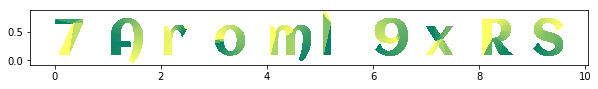

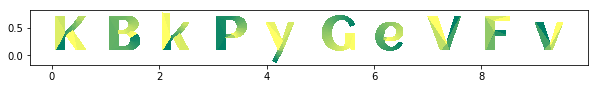

In [0]:
# Plot first row of original data
dataset_iter = dataset.make_one_shot_iterator()
batch = dataset_iter.get_next()
with tf.Session():
  data = dict(batch)
  print(data)
  tri_stacks1 = data['tri_stack1'].eval()
  tri_stacks2 = data['tri_stack2'].eval()
  triangles = [TriangleStack.from_array(t).get_triangles() for t in tri_stacks1]
  drawTris(np.expand_dims(np.array(triangles), 0))
  triangles = [TriangleStack.from_array(t).get_triangles() for t in tri_stacks2]
  drawTris(np.expand_dims(np.array(triangles), 0))
  

# Model

In [0]:
def encoder(x, latent_dim, hidden_size):
  """Construct an inference network parametrizing a Gaussian.
  Args:
    x: Outlines.
    latent_dim: The latent dimensionality.
    hidden_size: The size of the neural net hidden layers.
  Returns:
    mu: Mean parameters for the variational family Normal
    sigma: Standard deviation parameters for the variational family Normal
  """
  layers = [x]
  with tf.name_scope("encoder"):
    # TODO: feed in glyph_onehot
    layers.append(tf.keras.layers.Conv1D(filters=4, kernel_size=5)(layers[-1]))
    layers.append(tf.keras.layers.MaxPool1D()(layers[-1]))
    layers.append(tf.keras.layers.Conv1D(filters=8, kernel_size=5)(layers[-1]))
    layers.append(tf.keras.layers.MaxPool1D()(layers[-1]))
    layers.append(tf.keras.layers.Conv1D(filters=16, kernel_size=5)(layers[-1]))
    layers.append(tf.keras.layers.MaxPool1D()(layers[-1]))
    layers.append(tf.keras.layers.Flatten()(layers[-1]))
    layers.append(tf.keras.layers.Dense(units=hidden_size, activation='elu')(layers[-1]))
    layers.append(tf.keras.layers.Dense(units=hidden_size, activation='elu')(layers[-1]))
    # The mean and log variance are unconstrained
    latent_mean = tf.keras.layers.Dense(latent_dim)(layers[-1])
    latent_log_var = tf.keras.layers.Dense(latent_dim)(layers[-1])
    return latent_mean, latent_log_var


def decoder(z, rnn_input, hidden_size):
  """Build a generative network parametrizing the likelihood of the data
  Args:
    z: Samples of latent variables
    hidden_size: Size of the hidden state of the neural net
  Returns:
    outputs: (batch_size, ARRAY_SHAPE) Generated glyphs
    samples: (batch_size, DIST_VARS) Samples used to initialise initial state LSTM
    distributions: (batch_size, 6) Prob distributions for LSTM initial state 
  """
  layers = [z]
  print("z:", layers[-1].shape)
  with tf.name_scope("decoder"):
    #DIST_VARS = 8
    layers.append(tf.keras.layers.Dense(units=hidden_size, activation='elu')(layers[-1]))
    #layers.append(tf.keras.layers.Dense(units=hidden_size//DIST_VARS*DIST_VARS, activation='elu')(layers[-1]))
    #dist_vars = tf.keras.layers.Dense(units=DIST_VARS, activation='sigmoid')(layers[-1])
    #print("dist_vars", dist_vars.shape)
    #tf.keras.layers.Reshape([DIST_VARS], name='dist_vars')(layers[-1])
    #     element_distributions = [
    #         tf.distributions.Bernoulli(logits=dist_vars[...,0], validate_args=True, allow_nan_stats=False),
    #         tf.distributions.Uniform(low=dist_vars[...,1], high=dist_vars[...,2], validate_args=True, allow_nan_stats=False),
    #         tf.distributions.Uniform(low=dist_vars[...,3], high=dist_vars[...,4], validate_args=True, allow_nan_stats=False),
    #         tf.distributions.Bernoulli(logits=dist_vars[...,5], validate_args=True, allow_nan_stats=False),
    #         tf.distributions.Exponential(rate=dist_vars[...,6], validate_args=True, allow_nan_stats=False),
    #         tf.distributions.Exponential(rate=dist_vars[...,7], validate_args=True, allow_nan_stats=False),
    #     ]
    #initial_state = tf.stack([tf.cast(dist.sample([6]), tf.float32) for dist in element_distributions])
    #initial_state = tf.transpose(initial_state)  # move batch dim from last to first
    #initial_state = tf.unstack(initial_state, num=6)#FLAGS.batch_size)
    LSTM_UNITS = 32
    initial_state = [tf.keras.layers.Dense(units=LSTM_UNITS, activation='sigmoid')(layers[-1]),
                    tf.keras.layers.Dense(units=LSTM_UNITS, activation='sigmoid')(layers[-1])]
    #print("initial_state", initial_state.shape)
    # Note that this cell is not optimized for performance on GPU. Please use
    # `tf.keras.layers.CuDNNLSTM` for better performance on GPU.
    #     bias_initializer = tf.keras.initializers.Constant()
    #     kernel_initializer = tf.keras.initializers.Constant()
    #     recurrent_initializer = 
    lstm_layer = tf.keras.layers.LSTM(units=LSTM_UNITS, return_sequences=True)
    layers.append(lstm_layer(rnn_input, initial_state=initial_state))
    layers.append(tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(TriangleStack.ARRAY_SHAPE[-1]))(layers[-1]))
    print("posterior: ", layers[-1].shape)
    return layers[-1], initial_state

    #old:
    #output = snt.Linear(np.prod(posterior_sample_shape))(hidden2)
    #logits = snt.BatchReshape(posterior_sample_shape)(output) # Q: are these really logits?
    #     samples = []
    #     samples.append(tf.to_float(
    #         tf.distributions.Normal(loc=logits[...,0:2], 
    #                                            scale=tf.sqrt(tf.clip_by_value(tf.exp(logits[...,2:4]), 1e-2, 2.0)),
    #                                            validate_args=True, allow_nan_stats=False)
    #     p_x_given_z2 = tf.distributions.Bernoulli(logits=logits[...,4:6],
    #                                               validate_args=True, allow_nan_stats=False)
    #     return tf.concat([p_x_given_z1.sample(), tf.to_float(p_x_given_z2.sample())], axis=-1), logits, p_x_given_z1, p_x_given_z2


# https://github.com/altosaar/variational-autoencoder/blob/master/vae.py

def train_graph(data):
  tri_stacks1 = data['tri_stack1']
  tri_stacks2 = data['tri_stack2']
  rnn_input = tri_stacks2[:-1]
  rnn_output = tri_stacks2[1:]

  with tf.name_scope('variational'):
    print("input: ", tri_stacks1.shape)
    latent_mean, latent_log_var = encoder(x=tri_stacks1,
                                          latent_dim=FLAGS.latent_dim,
                                          hidden_size=FLAGS.hidden_size)
    latent_stdev = tf.sqrt(tf.exp(latent_log_var))
    q_z = tf.distributions.Normal(loc=latent_mean, scale=latent_stdev)
    assert q_z.reparameterization_type == tf.distributions.FULLY_REPARAMETERIZED

  with tf.name_scope('model'):
    # The likelihood is Bernoulli-distributed with logits given by the
    # generative decoder network
    #posterior_predictive_samples, decoder_logits, p_x_given_z1, p_x_given_z2 = decoder(z=q_z.sample(), hidden_size=FLAGS.hidden_size)
    outputs, samples = decoder(q_z.sample(), rnn_input, hidden_size=FLAGS.hidden_size)
    #tf.summary.image('posterior_predictive', posterior_predictive_samples)

    p_z = tf.distributions.Normal(loc=np.zeros(FLAGS.latent_dim, dtype=np.float32),
                                  scale=np.ones(FLAGS.latent_dim, dtype=np.float32))
    # Take samples from the prior
    #     prior_predictive_samples, _, _, _ = decoder(z=p_z.sample(FLAGS.n_samples), hidden_size=FLAGS.hidden_size)
    #tf.summary.image('prior_predictive', tf.cast(prior_predictive_samples, tf.float32))

    # Take samples from the prior with a placeholder
    #z_input = tf.placeholder(tf.float32, [None, FLAGS.latent_dim])
    #p_x_given_z_logits = decoder(z=z_input, hidden_size=FLAGS.hidden_size)
    #prior_predictive_inp = tf.distributions.Bernoulli(logits=p_x_given_z_logits)
    #prior_predictive_inp_sample = prior_predictive_inp.sample()

    # Build the evidence lower bound (ELBO) or the negative loss
    kl = tf.reduce_sum(tf.distributions.kl_divergence(q_z, p_z), 1)
#     expected_log_likelihood1 = tf.reduce_sum(p_x_given_z1.log_prob(x[...,:Stroke.PenDown]), [1, 2])
#     expected_log_likelihood2 = tf.reduce_sum(p_x_given_z2.log_prob(x[...,Stroke.PenDown:]), [1, 2])
    #global debug1, debug2, debug3
    #debug1 = tf.reduce_max(p_x_given_z1.log_prob(x[...,:Stroke.PenDown]))
    #debug2 = tf.reduce_max(p_x_given_z2.log_prob(x[...,Stroke.PenDown:]))
    #debug3 = kl
#     elbo = tf.reduce_sum(expected_log_likelihood1 + expected_log_likelihood2 - kl, 0)
    
    # try optimising raw encoder/decoder
    # compare posterior 0:2 (mean) with DX/DY, and 4:6 (bernoulli p) with bool PenDown/EndOfGlyph
    #raw_loss = tf.reduce_sum(kl) + tf.losses.mean_squared_error(x[...,0:2], decoder_logits[...,0:2]) + \
    #  tf.losses.mean_squared_error(x[...,2:4], decoder_logits[...,4:6])
    #raw_loss = tf.reduce_sum(kl) + tf.losses.mean_squared_error(x, posterior_predictive_samples)
    raw_loss = tf.reduce_sum(kl) + tf.losses.mean_squared_error(rnn_output, outputs)
    
    optimizer = tf.train.AdamOptimizer(learning_rate=0.001)
    #return optimizer.minimize(-elbo), -elbo, posterior_predictive_samples, prior_predictive_samples
    return optimizer.minimize(raw_loss), raw_loss#, posterior_predictive_samples, prior_predictive_samples

class FLAGS(): 
  logdir = "/tmp/tflog"
  iterations = 100000
  hidden_size = 32
  latent_dim = 16
  n_samples = 5
  print_every = 100
  batch_size = 100

# batch_input_shape = [FLAGS.batch_size, max_outline_points, Stroke.Size]
# input_shape = [outline_points, Stroke.Size]
#posterior_sample_shape = [outline_points, 6] # 2x(mean, stdev, bool)
#buffer_size=100
#batched_dataset = dataset.shuffle(buffer_size)
#batched_dataset = batched_dataset.repeat()
#batched_dataset = batched_dataset.batch(FLAGS.batch_size)
dataset_iter = dataset.make_one_shot_iterator()
batch = dataset_iter.get_next()
data = dict(batch)
# train_op, loss, posterior_predictive_samples, prior_predictive_samples = train_graph(outlines)
train_op, loss = train_graph(data)

# Merge all the summaries
summary_op = tf.summary.merge_all()
    

input:  (?, 150, 6)
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.distributions`.
Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.distributions`.
z: (?, 16)
posterior:  (?, 150, 6)
Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.distributions`.
Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Use tf.cast instead.


# Training

In [0]:
# Run training
with tf.Session() as sess:
  init = tf.global_variables_initializer()
  sess.run(init)

  #print('Saving TensorBoard summaries and images to: %s' % FLAGS.logdir)
  #train_writer = tf.summary.FileWriter(FLAGS.logdir, sess.graph)

  t0 = time.time()
  for i in range(FLAGS.iterations+1):
    #print(loss.eval())

    #sess.run([tf.add_check_numerics_ops(), train_op])
    sess.run(train_op)

    # Print progress and save samples every so often
    if i % FLAGS.print_every == 0:
      np_loss = sess.run(loss)
      #train_writer.add_summary(summary_str, i)
      print('Iteration: {0:d} loss: {1:.3f} s/iter: {2:.3e}'.format(
          i,
          np_loss / FLAGS.batch_size  * 1e9,
          (time.time() - t0) / FLAGS.print_every))
      t0 = time.time()

      # Save samples
#       np_posterior_samples, np_prior_samples = sess.run(
#           [posterior_predictive_samples, prior_predictive_samples])
      # for k in range(FLAGS.n_samples):
    if i % (FLAGS.print_every*50) == 0:
      display(drawOutlines(posterior_predictive_samples.eval(), cellsize=10, glyphCount=glyphNum))
      #display(drawOutlines(np_prior_samples, cellsize=30, glyphCount=glyphNum))
      #f_name = os.path.join(FLAGS.logdir, 'iter_%d_posterior_predictive_%d_data.jpg' % (i, k))
      #imsave(f_name, np_x[k, :, :, 0])
      #f_name = os.path.join(FLAGS.logdir, 'iter_%d_posterior_predictive_%d_sample.jpg' % (i, k))
      #imsave(f_name, np_posterior_samples[k, :, :, 0])
      #f_name = os.path.join(FLAGS.logdir, 'iter_%d_prior_predictive_%d.jpg' % (i, k))
      #imsave(f_name, np_prior_samples[k, :, :, 0])


InvalidArgumentError: ignored

In [0]:
      # Plot the posterior predictive space
      #     if FLAGS.latent_dim == 2:
      #       np_q_mu = sess.run(q_mu, {x: np_x_fixed})
      #       cmap = mpl.colors.ListedColormap(sns.color_palette("husl"))
      #       f, ax = plt.subplots(1, figsize=(6 * 1.1618, 6))
      #       im = ax.scatter(np_q_mu[:, 0], np_q_mu[:, 1], c=np.argmax(np_y, 1), cmap=cmap,
      #                       alpha=0.7)
      #       ax.set_xlabel('First dimension of sampled latent variable $z_1$')
      #       ax.set_ylabel('Second dimension of sampled latent variable mean $z_2$')
      #       ax.set_xlim([-10., 10.])
      #       ax.set_ylim([-10., 10.])
      #       f.colorbar(im, ax=ax, label='Digit class')
      #       plt.tight_layout()
      #       plt.savefig(os.path.join(FLAGS.logdir,
      #                                'posterior_predictive_map_frame_%d.png' % i))
      #       plt.close()

      #       nx = ny = 20
      #       x_values = np.linspace(-3, 3, nx)
      #       y_values = np.linspace(-3, 3, ny)
      #       canvas = np.empty((28 * ny, 28 * nx))
      #       for ii, yi in enumerate(x_values):
      #         for j, xi in enumerate(y_values):
      #           np_z = np.array([[xi, yi]])
      #           x_mean = sess.run(prior_predictive_inp_sample, {z_input: np_z})
      #           canvas[(nx - ii - 1) * 28:(nx - ii) * 28, j *
      #                  28:(j + 1) * 28] = x_mean[0].reshape(28, 28)
      #       imsave(os.path.join(FLAGS.logdir,
      #                           'prior_predictive_map_frame_%d.png' % i), canvas)
      # plt.figure(figsize=(8, 10))
      # Xi, Yi = np.meshgrid(x_values, y_values)
      # plt.imshow(canvas, origin="upper")
      # plt.tight_layout()
      # plt.savefig()
